My two favorite types of machine learning models are the support vector machine (SVM) and the neural network. Neural networks are great for making sense of a huge amount of training examples with each datum having hundreds or even hundreds of thousands of features. But neural networks don't tend to perform as well as other models on small data sets with only a few hundred data points or a very small numbers of features. Data sets with a few hundred to a few thousand training examples and a hand full of features are the sweet spot for SVM's. But where neural networks are great at engineering their own features SVM's require careful feature selection for good performance.

Because of their very different strengths and weaknesses it can sometimes be fruitful to combine SVM and a neural network together into a single model. The way in which I have seen this done previously is to use the neural network as a feature extractor for the SVM. The neural network is trained normally and then as a post processing step the final layer of the neural network is removed and replaced with a SVM which is fed the activations of the second to last layer as features. The ability of a neural network to compress a large amount of information down to a few relevant features and SVM's ability to squeeze the most out of a small number of data points is a great combination.

Although this method works it isn't very satisfying. Often the features that work best as the last layer of features in a neural network are very different than the features that would work best as features for an SVM classifier. A fresh hyper parameter search for the SVM after every tweak to the neural network works but is painful and awkward. Not to mention that there is no guarantee that the neural network features will be well adapted for use by the SVM even with a hyper parameter search over kernel parameters. Wouldn't it be nice if instead of learning an SVM as a post processing step we could incorporate it in to the neural network architecture directly? 

<!-- TEASER_END -->


## Smooth Kernel Machines

We will take a moment to consider roughly how SVM models work then propose a simplification suitable for use as a layer in gradient descent machine learning models which we will call "Smooth Kernel Machines" SKM.

A SVM works by analyzing the similarities between new data and training samples. You pick a function $K(x_1, x_2) \in \mathcal{R}$ that tells you how similar two points are to each other. $K$ is called the kernel function of the SVM. The classification of SVM is calculated as a weighted sum of the kernel over the training data $X$ with coefficients calculated as a function of all the training data $X_t$ and the associated labels $Y_t$.

$$
f(x) = \sum_{x_i \in X_t} c_i(X_t, Y_t) K(x, x_i)
$$

If this sum exceeds some threshold $f(x) > b$ then x is classified as a positive example and if the sum is negative it is classified as a negative example. In a regular SVM model the coefficients $c_i(X, Y)$ are calculated using a formalism involving linearly constrained optimization which is guaranteed to find the global optimum of a special loss function.
The trouble with putting the above expression in to a neural network is that the way that the coefficients $c_i(X, Y)$ depend on the training data is not perturbatively stable, that means small changes in the input features $X$ can cause arbitrarily large changes to the optimal coefficients $c_i(X)$, making solution by gradient descent not a good idea. Also the actual calculation of the coefficients can be very computationally expensive making the calculation of the gradient of $c_i(x)$ at every training iteration very inefficent.

There is a very close parallel here to radial basis function networks (RBFN). In a RBFN the kernel function depends only on $|x_1-x_2|$ and we replace the sum over the entire dataset with a sum over a small constant set of exemplar points, treating $c_i$ and $x_i$ as free parameters of the model. This solution works just fine but it gives up a key regularizing feature of SVM's which is that by keeping the sum as being evaluated on actual data points we concentrate the degrees of freedom of the model in exactly the places where we have more data.

A different solution would be to simply evaluate the coefficents on small mini batches but keep the usual SVM optimization startegy. However this will make the perturbative instability problem go from bad to worse especially as the size of the mini batches gets smaller and smaller. But we needn't use the usual SVM method of coefficient estimation. We can instead use a simpler closed form solution which can be quickly evaluated and equally importantly easily differentiated.

I think the set of coefficients which most readily comes to mind is to solve the linear system $y=K_{i,j}c$ via least squares. Since we have the same number of coefficients as target values to predict we can always find an exact solution. However data points very near to each other $x_i \approx x_j$ will create nearly degenerate columns in the similarity matrix making the linear model very poorly conditioned and so making the resulting function very unstable mini batch to mini batch.

The idea I'm going to promote here is that we simply use the kernel function as a weight for calculating a weighted average of the target variable $y$. Written out that is,

$$
f(x) = \bar{y}(x) = \frac{v\epsilon + \sum_{x_i, y_i \in X_t, Y_t} y_i~K(x, x_i)}{\epsilon + \sum_{x_i \in X_t} K(x, x_i)}
$$

Here $v$ is a dummy observation with a small weight $\epsilon$ to prevent the "average" value from diverging to infinity where the sum of the kernel function over the training batch drops to 0. 

Note that this formulation only makes sense if our similarity is always positive. This is a very reasonable restriction, the most popular (and typically best performing) kernel is the Gaussian kernel $K(x_1, x_2) = G(r_{12}) = exp(-\gamma \sum (x_1-x_2)^2)$ with the width parameter $\gamma$ controlling how close two data points need to be in order to be considered similar enough to affect each others classification. In fact the Gaussian kernel is so popular that it is often known simply as the <a href=https://en.wikipedia.org/wiki/Radial_basis_function_kernel> radial basis function kernel </a>.

### Regularization .

If we are using this as a machine learning model on its own with fixed input features X and a fixed kernel then there is nothing wrong with the formulation above. However if the input features $x$ represent the outputs of a neural network  acting as a feature extractor then we still have some work to do. Since we have allowed the value of $\bar{y}(x)$ to depend on the training data including $y_i$ the only way to always be certain to get a near perfect prediction on the test data $\bar{y}(x_i) =  y_i$ is to make the similarities go to zero $K(x_i, x_j) \approx 0$ for $i \neq j$. Thus during training via gradient descent we will tend to reward ANY change of the neural network parameters which results in larger average distances between any two points, which is obviously not going to give us a model that generalizes well.

Another way to look at the problem is that we are feeding our desired output as an input to our model, which can get us into trouble. The usual way to deal with this kind of information leakage from our labels is to use some sort of cross validation. We withold some data from our model during training and then check how well it perfroms on that data after training. Because we have a closed form solution for our function in this case it turns out to be trivial to find what our SKM model would give us were we to exclude a single pair of input and target $x_j$, $y_j$. We simply subtract out the contribution from the sums coming from that particular datum.

$$
f_j(x) = \bar{y_j}(x) = \frac{v\epsilon - y_jK(x_j, x_j) + \sum_{x_i, y_i \in X_t, Y_t} y_i~K(x, x_i)}{\epsilon + K(x_j, x_j) + \sum_{x_i \in X_t} K(x, x_i)}
$$

This acts as a sort of online version of a leave one out cross validation employed as a regularization strategy. This forces the neural network to reduce the training error by moving $x_i$ with similar $y_i$ closer together instead of farther appart which is exactly what we want. Thus we can use this leave one out adapted function to evaluate the SKM model on the training data and then the regular weighted average to evalute $\bar{y}$ on never before seen data. Although this is a snazzy regularization strategy it is important to note that this isn't really leave one out cross validation because the neural features $x$ can still easily learn to overfit to the data the leave one out adjusted function is just a sort of smart regularization to the gradient.

# Toy Data Set

In order to test whether or not this idea has any merit lets try to invent a toy model data set on which we expect that SKM should work well. We will begin by analyzing the dataset by SVM, and a neural network + SVM hybrid like we were talking about at the beginning of this post and then apply our new proposed SKM.

A frequently encountered and sometimes very challenging situation is where our features only have predictive power when combined with many other features. This situation is greatly exacerbated by the fact that since each feature by itself looks like a very weak feature we cannot always rely on a quick one at a time feature selection process to find the features that will end up being the most useful. The classic example of this of course is image recognition. Our input features are pixel intensities but each pixel by itself is such a weak feature that it hardly seems useful. In the case of image recognition it is only by combining hundreds or thousands of pixel intensities together that we can create useful features.

As a simple version of this scenario we will look at trying to learn a classification for points in 10 dimensional space where the points are in the positive class if they lie withinin a narrow ring in their first two input dimensions. The remaining dimensions are fillled with irrelevant noise.

### Data Set Generation

In [1]:
import numpy as np
np.random.seed(1234)
import matplotlib.pyplot as plt
from sklearn import svm
import sklearn.metrics
import sklearn.decomposition

In [2]:
plt.rcParams.update(
    {
        "figure.figsize":(12, 6),
        "font.size":15,
        "image.cmap":"PuOr",
    }
)

In [3]:
def make_ring_dataset(
    n_samples, 
    n_col_total, 
    n_informative, 
    rsq_bounds,
):
    x = np.random.normal(size=(n_samples, n_col_total))
    r_sq = np.sum(x[:, :n_informative]**2, axis=1)
    y = (r_sq > rsq_bounds[0])*(r_sq < rsq_bounds[1])
    return x, y

In [4]:
n_train = 1000
n_test = n_train
total_dimensions = 10
informative_dimensions = 2

dataset_kwargs = dict(
    n_col_total=total_dimensions,
    n_informative=informative_dimensions,
    rsq_bounds=(0.5, 1.5),
)

train_x, train_y = make_ring_dataset(
    n_samples=n_train,
    **dataset_kwargs
)

test_x, test_y = make_ring_dataset(
    n_samples=n_test,
    **dataset_kwargs
)

#for convenience in training the neural nets one hot encode the y
train_y_onehot = np.stack([1-train_y, train_y], axis=1)
test_y_onehot = np.stack([1-test_y, test_y], axis=1)

### Classification Difficulty

This is a fairly difficult classification problem and represents an almost adversarial example for training either a neural network or a support vector machine. The spherical symmetry causes trouble for the neural network and the irrelevant data columns cause troulbe for the SVM.

The spherical symmetry is such that the negative and positive classes tend to have very similar distributions to each other in any one random projection. Since neural networks are a series of projections followed by some sort of thresholding (e.g. relu or tanh activations) this makes training a neural network on this data very slow and difficult.

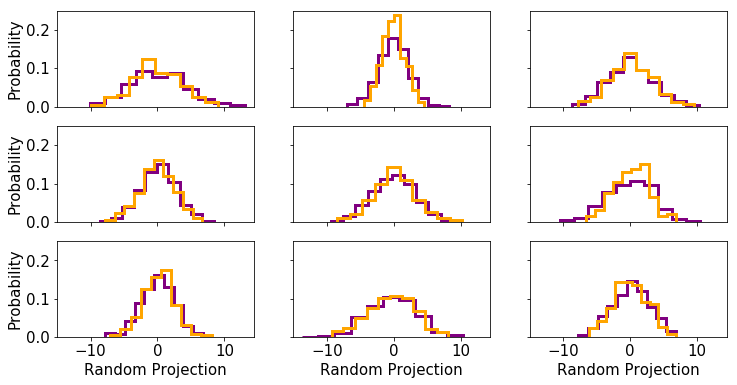

In [5]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True)
for ax in axes[2]:
    ax.set_xlabel("Random Projection")

for ax in axes[:, 0]:
    ax.set_ylabel("Probability")

axes = axes.ravel()

for i in range(len(axes)):
    ax = axes[i]
    random_proj = np.random.normal(size=(total_dimensions,))
    x_proj = np.dot(train_x, random_proj)
    x_proj_0 = x_proj[train_y==0]
    x_proj_1 = x_proj[train_y==1]
    ax.hist(x_proj_0, color="purple", histtype="step", normed=True, lw=3)
    ax.hist(x_proj_1, color="orange", histtype="step", normed=True, lw=3)

Because the SVM acts only on the similarity between data points the spherical symmetry poses no problems at all for learning the classification function. The SVM will be able to learn a good classifier if points which are of the same class tend to have much higher similarities to each other than the cross class similarities. 

Without doing lots of careful feature selection/engineering and hyper parameter selection for choosing the kernel it is extremely difficult for the SVM to learn to ignore spurious similarities between input data. In this case because we have many more irrelevant features than we have relevant features the similarity between data points is dominated by the distance between points in the irrelevant dimensions and so SVM using all of the available features at once performs very poorly.

In [6]:
def classification_plot(
    x,
    y,
    ax=None,
):
    if ax is None:
        fig, ax = plt.subplots()
    vmin, vmax = -0.25, 1.25
    ax.scatter(x[:, 0], x[:, 1], c=y, alpha=0.85, vmin=vmin, vmax=vmax)
    ax.set_xlabel("$x_1$", fontsize=20)
    ax.set_ylabel("$x_2$", fontsize=20)
    

accuracy 0.598
ROC AUC 0.512623761225


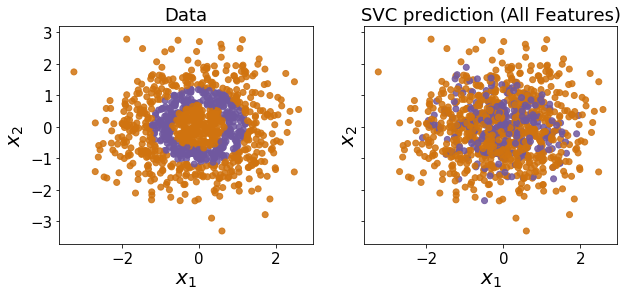

In [7]:
svc = svm.SVC(
    C=20.0,
    kernel="rbf",
)
svc.fit(train_x, train_y)
pred_y_svc = svc.predict(test_x)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

print("accuracy", sklearn.metrics.accuracy_score(test_y, pred_y_svc))
print("ROC AUC", sklearn.metrics.roc_auc_score(test_y, pred_y_svc))

classification_plot(test_x, test_y, ax=axes[0])
classification_plot(test_x, pred_y_svc, ax=axes[1])

axes[0].set_title("Data")
axes[1].set_title("SVC prediction (All Features)");

With all the irrelevant features junking up the similarity between points the SVM loses its way completely and its predictions become very poor, dominated by what points happen to be close to each other in the 8 irrelevant dimensions instead of the 2 relevant ones. 

Note that if we cheat and do some human feature selection/engineering beforehand and use only just the 2 relevant dimensions the SVM classifier has absolutely no trouble learning the classification function.

accuracy 0.981
ROC AUC 0.983562835126


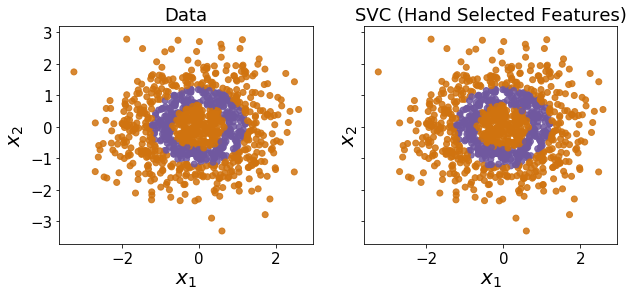

In [8]:
svc = svm.SVC(
    C=20.0,
    kernel="rbf",
    gamma=0.5,
)
svc.fit(train_x[:, :2], train_y)
pred_y_svc = svc.predict(test_x[:, :2])

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

print("accuracy", sklearn.metrics.accuracy_score(test_y, pred_y_svc))
print("ROC AUC", sklearn.metrics.roc_auc_score(test_y, pred_y_svc))

classification_plot(test_x, test_y, ax=axes[0])
classification_plot(test_x, pred_y_svc, ax=axes[1])

axes[0].set_title("Data")
axes[1].set_title("SVC (Hand Selected Features)");

## Neural Network

What happens if we try to fit a neural network feature extractor? With enough training data the neural network should be able to act as a filter getting rid of the irrelevant information in the extra dimensions and finding useful features. As I mentioned earlier, neural networks don't tend to work well on such small datasets and just 1,000 examples may not be enough to do well on this particular task.

It took me quite a while to find a neural network architecture and a set of optimizer parameters which worked well. Too many filters in the first couple layers leads to significant overfitting but you need at least 10 or so to get decent results. The feature embedding layer has intentionally been kept with just a few filters because that will tend to give better results when combining with SVM as a post processing step. The neural network tends to perform slightly better with more features in the second to last layer but not significantly so. Without the dropout regularization between the first two layers the network struggles to achieve any kind of accuracy, tending to overfit after a few tens of epochs without having learned any useful features. Even with the dropout regularization the network sometimes fails to train significantly for dozens of epochs due to unfortunate initialization.

In [9]:
import keras
import tensorflow as tf

from keras.layers import Conv3D, MaxPooling3D, AveragePooling3D, GlobalAveragePooling3D, Dense, Input, BatchNormalization

Using TensorFlow backend.


In [10]:
x_in = keras.layers.Input((total_dimensions,))

x = x_in
x = Dense(60, activation="relu",)(x)
x = keras.layers.Dropout(0.2)(x)
x = Dense(20, activation="relu",)(x)
x = Dense(4, activation="relu",)(x)
nn_embedding = x
x = Dense(2, activation="softmax")(x)
nn_prob = x

nn_model = keras.models.Model(x_in, nn_prob)

In [11]:
optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.8)
nn_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [12]:
nn_training_history = nn_model.fit(
    train_x, 
    train_y_onehot,
    epochs=200,
    batch_size=256,
    verbose=False,
    validation_data=(test_x, test_y_onehot)
)

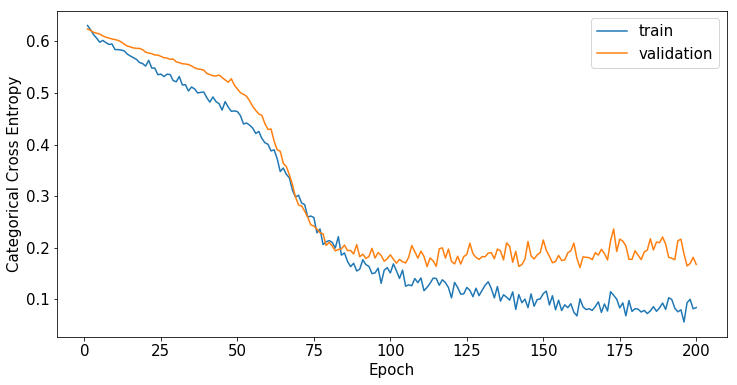

In [13]:
training_losses = nn_training_history.history["loss"]
val_losses = nn_training_history.history["val_loss"]

plt.plot(np.arange(1, len(training_losses)+1), training_losses, label="train")
plt.plot(np.arange(1, len(val_losses)+1), val_losses, label="validation")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Categorical Cross Entropy");

The sharp improvement in performance in the above plot correspond to the network learning to classify the points interior to the ring. At first the network steadily learns to classify points which are outside of the outer radius of the ring as belonging to the negative class. This is significantly easier than learning to classify the very inner most points as being part of the negative class and the network performance improves slowly for a long while. Eventually a lucky set of parameter perturbations leads to a set of features that allow the innermost points to also be correctly classified and the performance rapidly improves. See the embedding comparison section later in this post for more.

accuracy 0.922
ROC AUC 0.981079472262


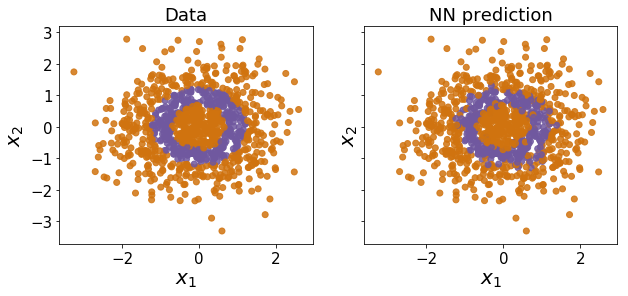

In [16]:
pred_y_nn_prob = nn_model.predict(test_x)[:, 1]
pred_y_nn = pred_y_nn_prob > 0.5

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

print("accuracy", sklearn.metrics.accuracy_score(test_y, pred_y_nn))
print("ROC AUC", sklearn.metrics.roc_auc_score(test_y, pred_y_nn_prob))
    
classification_plot(test_x, test_y, ax=axes[0])
classification_plot(test_x, pred_y_nn, ax=axes[1])

axes[0].set_title("Data")
axes[1].set_title("NN prediction");

With a well chosen architecture, appropriate regularization, a lucky set of starting parameters, and enough training epochs the neural network can eventually learn the target classification fairly well. However there is a large amount of variation in perfomance of models with different parameter initializations or different realizations of the ring data set.

## NN + SVC (post processing)

Treating the neural network as a feature extractor and training a SVM classifier head sometimes results in a performance boost as discussed at the start of the post. Lets see if it happened in this particular case.

We can't incorporate the SVC directly into the keras model and so we need to first extract the neural network features and then fit them using the sklearn SVC implementation.

In [17]:
nn_embedding_model = keras.models.Model(x_in, nn_embedding)

nn_embed_train = nn_embedding_model.predict(train_x)
nn_embed_test = nn_embedding_model.predict(test_x)

accuracy 0.926
ROC AUC 0.919962703052


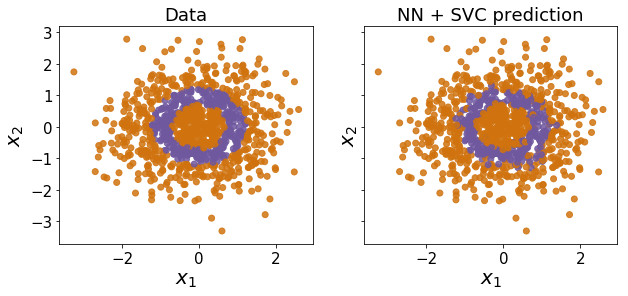

In [19]:
nn_svc = svm.SVC(
    gamma=3.0,
    kernel="rbf",
)
nn_svc.fit(nn_embed_train, train_y)
pred_y_nn_svc = nn_svc.predict(nn_embed_test)
nn_svc_decf = nn_svc.decision_function(nn_embed_test)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

print("accuracy", sklearn.metrics.accuracy_score(test_y, pred_y_nn_svc))
print("ROC AUC", sklearn.metrics.roc_auc_score(test_y, nn_svc_decf))

classification_plot(test_x, test_y, ax=axes[0])
classification_plot(test_x, pred_y_nn_svc, ax=axes[1])

axes[0].set_title("Data")
axes[1].set_title("NN + SVC prediction");

The SVM post processing trick can be fickle. Although it can sometimes result in improved performance over justa a vanilla NN, in practice it requires a lot of babysitting to get right, with hyper parameter searches and rounds of feature engineering (e.g. adding in some categorical metadata etc). Even then it can be a real challenge to avoid the effects of overfitting even more so than when using either an NN or an SVM alone.

For example if the neural network learns to nearly perfectly predict the training data then the SVC will simply re-learn the linear separator represented by the last layer of the neural net (re-learn it poorly if you are using an RBF kernel) which isn't going to give you a performance boost. You can counter this to some degree by stopping your network training very early. So that train and validation accuracies are similar with the hope that this will leave enough structure for the SVM to exploit. However, this makes the NN+SVC system very unstable much more so than either sort of classifier alone. I have had some good experiences with an averaging or voting scheme using the predictions of a bag of NN+SVC systems trained in this way. However there is a lot of overhead involved in training and evaluating such a model. But ensembling together a lot of high variance models to get a lower variance estimator is just putting a band-aid on the real problem of unstable training/poor regularization. We can of course endlessly tinker with regularization strengths and/or entirely different sorts of model regularization but this can be exhausting and not at all guaranteed to meet with success.

Wouldn't it be great if we could side step all of the stability issues that come with stacking models and simply incorporate an SVM like classifier directly in to the training of the feature extracting network? 
I've already outlined above how I think this might be carried out in principle lets see how well that formulation works on this particular learning problem.

## SKM Implementation

OK, time to dig in and implement the SKM model as an integrated top layer for a neural network and see if that makes a difference. First we need a distance matrix implementation in tensorflow a nifty way to calculate it can be adapted from an answer to <a href=https://stackoverflow.com/questions/37009647/compute-pairwise-distance-in-a-batch-without-replicating-tensor-in-tensorflow>this stack overflow question</a>.

In [20]:
def tf_pairwise_sq_distance_matrix(x1, x2):
    r1 = tf.reduce_sum(x1*x1, 1)
    r2 = tf.reduce_sum(x2*x2, 1)
    r1 = tf.reshape(r1, [-1, 1])
    r2 = tf.reshape(r2, [-1, 1])
    D = r1 - 2*tf.matmul(x1, tf.transpose(x2)) + tf.transpose(r2)
    return D

If the formulas in the function above is mystifying think of it as just a vectorized (tensorized?) rewriting of the identity $(x_1-x_2)^2 = x_1^2 -2x_1 x_2 + x_2^2$. lets make some test data and compare the results to the scipy.spatial.distance_matrix function to make sure that we don't have any bugs in the distance calculation.

In [21]:
#generate some randomized test data
x1_rand, x2_rand = np.random.normal(size=(100, 8)), np.random.normal(size=(50, 8))

import scipy.spatial
import keras.backend as K

scipy_dsq = scipy.spatial.distance_matrix(x1_rand, x2_rand)**2

sess = K.get_session()
#make some placeholders to feed our data in with
x1_ph = tf.placeholder(dtype=np.float32)
x2_ph = tf.placeholder(dtype=np.float32)
#build the squared distance matrix tensor 
dsq_tensor = tf_pairwise_sq_distance_matrix(x1_ph, x2_ph)
#run the operation
tf_dsq = sess.run(dsq_tensor, feed_dict={x1_ph:x1_rand, x2_ph:x2_rand})

#check that the difference in calculated squared distances are small
np.mean(np.abs(scipy_dsq-tf_dsq))

7.3988534727411627e-07

With a nice utility for calculating distance matrices under our belt it is a simple matter to implement the SKM equations where we apply a radial basis kernel to the squared distances to get our similarity matrix. The function make_skm_head below is a slight generalization of what we discussed before in that the target value y is expected to have multiple channels but each channel is averaged using the same kernel weights.

In [22]:
def make_skm_head(
    input_x,
    input_y,
    output_x,
    kernel,
    k0,
    central_value,
    sm_eps,
):
    x1 = input_x
    if output_x == None:
        x2 = x1
    else:
        x2 = output_x
    
    sq_dists = tf_pairwise_sq_distance_matrix(x2, x1)
    sim_mat = kernel(sq_dists)
    
    numerator = (central_value*sm_eps + tf.einsum("ij,jk->ik", sim_mat, input_y))
    denominator = tf.expand_dims((sm_eps + tf.reduce_sum(sim_mat, axis=1)), axis=1)
    
    if output_x==None:
        numerator = numerator - k0*input_y
        denominator = denominator - k0
    
    pred = numerator/denominator
    
    return pred

Because we want to use the leave one out expression during training feeding the same x in as the input and output x values it is convenient to make two different models with a shared set of feature extraction layers which feed into two seperate SKM classification heads, one for training which uses the leave one out averaging formula and one for prediction which uses the regular average and takes an additional set of input data for prediction.

I tried to keep the architectures of the neural network leading in to the SKM as similar to each other as possible to allow for a fair comparison of the two. However for some reason the vanilla neural network trains much better with relu activations and the SKM model trains much better with a smooth activation function like elu. Also you will note that the last layer has no activation function and no bias. Because the SKM prediction averaging is a very nonlinear transform the non-linearity in the output layer is not necessary. Also since most activation functions have places where data tends to pile up (e.g. the 0 threshold for relu or both the +1 and -1 thresholds for tanh) this gives a signal to the SKM that things near these boundaries are very similar to each other. Since there can be an awful lot of these edges in high dimensional spaces the edge similarity effects come to be an important part of the total SKM learned similarity function. While this is not necessarily a bad thing it doesn't appeal to my personal sense of aesthetics.  

In [23]:
x_basis_skm = keras.layers.Input((total_dimensions,))
x_pred_skm = keras.layers.Input((total_dimensions,))
y_basis_skm = keras.layers.Input(shape=(2,))

layers = []
layers.append(Dense(60, activation="elu"))
layers.append(keras.layers.Dropout(0.2))
layers.append(Dense(20, activation="elu"))
layers.append(Dense(4, activation=None, use_bias=False))

#build two feature extraction nets with shared layers
nn_embedding_basis = x_basis_skm
nn_embedding_pred = x_pred_skm

for layer in layers:
    nn_embedding_basis = layer(nn_embedding_basis)
    nn_embedding_pred = layer(nn_embedding_pred)

kernel_gamma = 3.0
sim_kernel_tf = lambda x: tf.exp(-kernel_gamma*x)
sim_kernel_np = lambda x: np.exp(-kernel_gamma*x)

skm_kwargs = dict(
    kernel=sim_kernel_tf,
    k0=sim_kernel_np(0.0),
    central_value=0.5,
    sm_eps=0.01,
)

skm_func_train = lambda x: make_skm_head(
    input_x=x[0],
    input_y=x[1],
    output_x=None, 
    **skm_kwargs
)

skm_func_predict = lambda x: make_skm_head(
    input_x=x[0],
    input_y=x[1],
    output_x=x[2], 
    **skm_kwargs
)

training_tensor = keras.layers.Lambda(skm_func_train)([nn_embedding_basis, y_basis_skm])
pred_tensor = keras.layers.Lambda(skm_func_predict)([nn_embedding_basis, y_basis_skm, nn_embedding_pred,])

skm_training_model = keras.models.Model([x_basis_skm, y_basis_skm], training_tensor)
skm_prediction_model = keras.models.Model([x_basis_skm, y_basis_skm, x_pred_skm], pred_tensor)

In [24]:
optimizer = keras.optimizers.SGD(lr=0.1, nesterov=True, momentum=0.8)
skm_training_model.compile(loss="categorical_crossentropy", optimizer=optimizer)

In [25]:
skm_history = skm_training_model.fit(
    [train_x, train_y_onehot],
    train_y_onehot,
    batch_size=256,
    epochs=200,
    verbose=False,
)

unfortunately because the training model and the predict time model have different call signatures it isn't quite as easy to plot up the train and test losses simultaneously but we can still get an idea of the manner in which our model is training by looking at just the training set loss.

Text(0,0.5,'Categorical Cross Entropy')

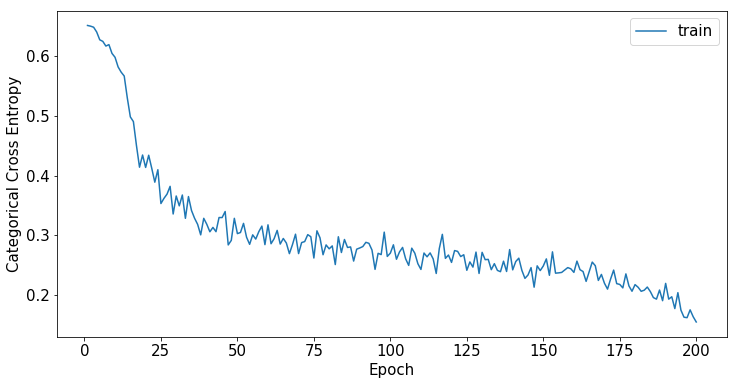

In [26]:
training_losses = skm_history.history["loss"]

plt.plot(np.arange(1, len(training_losses)+1), training_losses, label="train")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Categorical Cross Entropy")

The SKM model violates one of the basic assumptions of the keras framework which is that the predictions of our model are independent between samples. This is not the case for the SKM model since we feed in the training data as an input and then build the similarity matrix between all training examples and test data in order to evaluate the similarity weighted average. This trouble can be solved for this very particular case by making the number of train and test samples equal to each other and setting the batch size equal to the total number of data points. This is necessary because internally keras wants to split the prediction up into small batches with expectation that one row in the inputs represents one datum and that it can split the individual rows up as it likes into batches without changing the value of the prediction (which is not true for our SKM model).

This is not really a good solution for real world problems where we can't simply assert that we ought to have the same number of train and test samples. More over the full train/test similarity matrix may be too large to hold in memory all at once and we may require another way. If the full similarity matrix is not too large to compute without the aid of GPU acceleration I would suggest simply calculating the similarity matrix using sklearn.spatial.distance_matrix and a numpy version of your similarity kernel. If the resulting matrix would be too large then I would suggest bootstrap sampling from the rows of your training data in as large of batches as comfortably fit in memory. 

In [27]:
skm_probs = skm_prediction_model.predict(
    [train_x, train_y_onehot, test_x], 
    batch_size=1000,
)[:, 1]
skm_pred = skm_probs >= 0.5

ROC AUC 0.989192256
accuracy 0.945


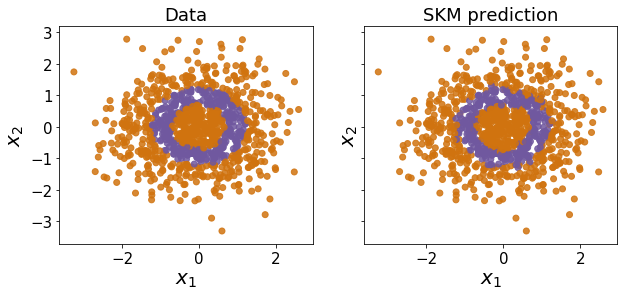

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

print("ROC AUC", sklearn.metrics.roc_auc_score(test_y, skm_probs))
print("accuracy", sklearn.metrics.accuracy_score(test_y, skm_pred))

classification_plot(test_x, test_y, ax=axes[0])
classification_plot(test_x, skm_pred > 0.5, ax=axes[1])

axes[0].set_title("Data")
axes[1].set_title("SKM prediction");

Success!

The SKM model performs really quite well. It trains more rapidly than the more conventional NN and performs better overall. Something that is difficult to glean from the plots above is that the neural network model was a lot more trouble than the SKM model to train. Fairly frequently the NN refused to train properly, immediately overfitting after just a few training epochs and then running off to a divergently bad model. The quality of the model was very dependent on the initializations and often even if the model did not diverge it never found a decently peforming model within 100 training epochs. Some of these difficulties might be improved by using a smaller learning rate for the NN but it seemed to me that the models found by using smaller learning rates were generally inferior to those found using the (admittedly very high) learning rate that was used for both the SKM and NN models.

A significant bonus for the SKM model is that it doesn't seem to ever overfit. Even with the dropout regularization the regular NN will eventually overfit if you run enough training epochs. In contrast the SKM model seemingly can take as many training iterations as you are willing to throw at it without over fitting. This may mean that our model is not flexible enough and we could up the model complexity to get better performance. This is significant since the model complexity for both the vanilla NN and the SKM models are the same! The leave one out style averaging is apparently paying off as a regularization strategy.

## Comparison of Embeddings

It is clear to me that SKM is really a nice technique for fitting neural embeddings (although that wasn't the way I originally conceived of it). An SKM model performs well if data with similar classifications (or any other properties you would care to input) are mapped near together. The key advantage that an SKM embedding has over a more normal NN embedding is that it enforces the requirement that points with similar properties be mapped together. In an approach where you use a complex neural network to map an embedding vector to a target value there is no need to keep the evolution of properties smooth, after all the neural network can fit arbitrarily complex mappings! 

Lets take a look at the embedding learned by the pure NN and by the SKM model and see if there are any obvious differences. Though both models learn a 4 dimensional representation the effect of the dropout regularization makes the 4 dimensions very linearly redundant with each other. We therefore lose little information by reducing the dimensionality of the embeddings from 4 to 2 using principal component analysis (PCA). This also removes some of the rotational degrees of freedom which might otherwise make direct comparison of the two embeddings difficult.

It is important to note that doing PCA on the embedding gives very different results than we would get by simply doing PCA on the original 10 dimensional input space. Since the data was chosen to be completely spherically symmetric in all 10 dimensions PCA on the raw data would simply give us back a random rotation of the input data.

In [26]:
skm_embedding_model = keras.models.Model(x_basis_skm, nn_embedding_basis)

skm_embed_train = skm_embedding_model.predict(train_x)
skm_embed_test = skm_embedding_model.predict(test_x)

In [27]:
pca_skm = sklearn.decomposition.PCA(n_components=2).fit(skm_embed_test)
u_skm = pca_skm.transform(skm_embed_test)

pca_nn = sklearn.decomposition.PCA(n_components=2).fit(nn_embed_test)
u_nn = pca_nn.transform(nn_embed_test)

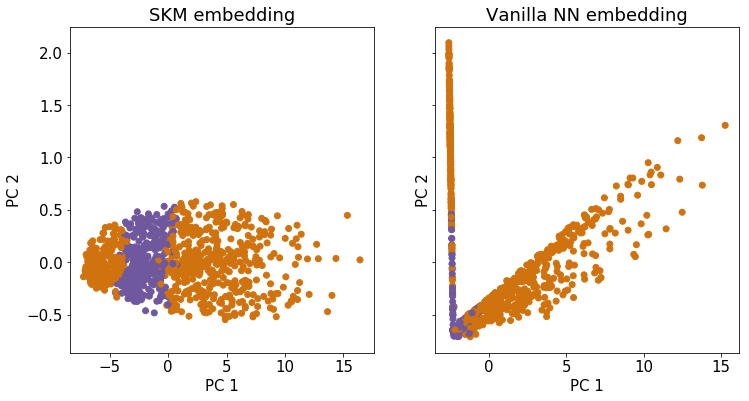

In [29]:
fig, axes = plt.subplots(1, 2, sharey=True)

for ax in axes:
    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")

axes[0].scatter(u_skm[:, 0], u_skm[:, 1], c=test_y, vmin=-0.25, vmax=1.25)
axes[0].set_title("SKM embedding")


axes[1].scatter(u_nn[:, 0], u_nn[:, 1], c=test_y, vmin=-0.25, vmax=1.25)
axes[1].set_title("Vanilla NN embedding");

I have to say that I find the SKM embedding much more visually pleasing than the vanilla NN embedding. However this has just as much to do with the different choice of activation functions as it has to do with the use of SKM. But one thing to note is that the last layer of the vanilla NN acts as a linear separator and so it needs all the points interior and exterior to the target ring to get mapped to one side of the points within the ring. The SKM model on the other hand since it is proximity based is perfectly happy to have multiple nodes of different classes distributed any way they like within the embedding plane just so long as points of the same class tend to be close to each other. 

The SKM embedding looks to have learned a feature which is essentially radius from the origin. The vanilla NN embedding doesn't immediately seem to have a clear intuitive explanation. Lets plot them both up with respect to radius and see what the relationship is between the learned features and the feature we might have put in as human feature engineers.

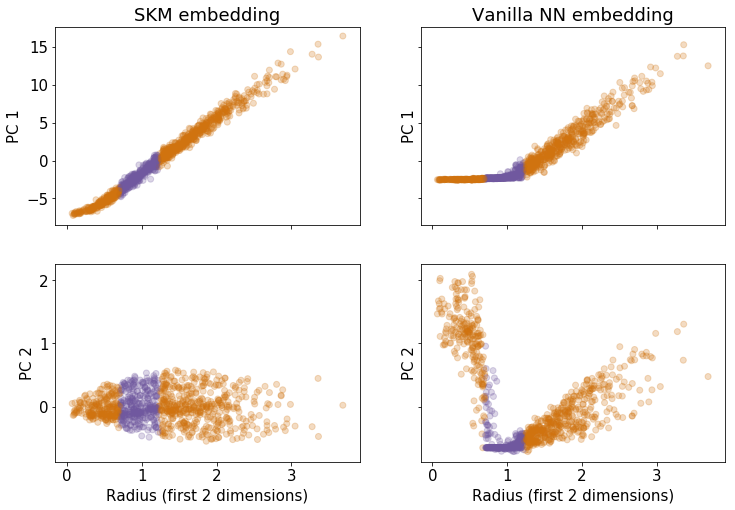

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey="row")

for ax in axes[0]:
    ax.set_ylabel("PC 1")

for ax in axes[1]:
    ax.set_ylabel("PC 2")
    ax.set_xlabel("Radius (first 2 dimensions)")

axes[0, 0].set_title("SKM embedding")
axes[0, 1].set_title("Vanilla NN embedding");

kwargs = dict(vmin=-0.25, vmax=1.25, c=test_y, alpha=0.25)

radius_x2 = np.sqrt(np.sum(test_x[:, :2]**2, axis=1))

axes[0, 0].scatter(radius_x2, u_skm[:, 0], **kwargs)
axes[0, 1].scatter(radius_x2, u_nn[:, 0], **kwargs)
axes[1, 0].scatter(radius_x2, u_skm[:, 1], **kwargs)
axes[1, 1].scatter(radius_x2, u_nn[:, 1], **kwargs);


Both embeddings clearly learned to extract radius dependent features. In the case of SKM radius alone as a feature suffices and the second principle component can be whatever it likes so long as points are tightly enough placed that each point tends to have a fair number of high similarity neighbors. On the other hand the vanilla NN requires the two classes to be linearly separable. Since we have blue points both interior to an inner radius and exterior to an outer radius there is no linear separator in radius alone. This forces the vanilla neural network to learn effectively 2 different features one for identifying points exterior to the ring (mostly PC1) and one for identifying points interior to the ring (mostly PC2). 

Although both the vanilla NN and the SKM features have a certain elegance to them I have a strong aesthetic preference for the SKM learned features. On top of the fact that the SKM model slightly out performs the NN model I can't help but be impressed with the fact that the SKM learned features so closely correspond to my own human feature engineering instincts.

# Final Thoughts

Overall I think that the SKM is not only a novel idea but seems to actually be a good idea, a much more valuable commodity. 

My original motivation was to make a version of an SVM classifier which was robust against the addition of irrelevant columns and which didn't require careful hyper parameter tuning. I think I have somewhat achieved both of these goals to some degree. You can see the near independence from the irrelevant input data because of the tight relationship between radius in the first two dimensions and the first principal component as visualized above. If you make the same plots for the radius in all dimensions there is very little correlation.

To see that we have achieved an embedding which is well adapted to our original choice of kernel note the relative difference in scale between the first and second principal components in the plots above. The dominance of the first principal component and its tight relationship with radius means that the 4D Gaussian kernel becomes dominated by the distance along the first principal vector. That means two points are "similar" if their radius is within about 1 kernel width parameter of each other (which is exactly what I might have done as a human feature engineer). For the vanilla NN when we apply an SVC as a post processing step the euclidean distance based similarity cannot be so easily reduced down simply to the difference in radius. Because of the way that the points are distributed along a swoosh/checkmark shape the relationship between difference in radius and distance in the embedding space is much more complicated, making the SVC classifiers job difficult.

Only application of this method to lots of real world problems can show whether or not it is useful in practice. I am eager to try it out on some standard data sets like MNIST and will probably make a post about that when I do. I also feel there is lots of room here for improvement/experimentation. For example the best way in which to evaluate SKM type models on test data (or the best way to generate mini batches or choose a batch size for that matter) clearly needs some work. Although the appeal of simply choosing random bootstrap samples of a fixed size as I suggested earlier in the post has a certain statistical elegance to it it is probably not the best option. Especially the more complicated the target variable(s) we are mapping. For example a bootstrap sampling for MNIST training labels should be fine just so long as the batch size is larger than say 100 or so making us confident that there is at least one example of each digit in each batch. However if we are analyzing ImageNet with 1,000 categories suddenly this doesn't seem like such a good idea since we would need batch sizes of 10,000 or more to get a similar guarantee. If we applied exactly the same procedure as we did in this kernel that would mean the generation of matrices of a size 10,000x10,000x1,000 which is not going to fit in most peoples available ram... I'm sure some way can be found around these difficulties for example training and predicting with forced stratified folds for each training and prediction batch making sure there is at least 1 of each target category in each batch. The over importance that this would give to categories with small numbers of samples could be somewhat accounted for by including a sample weight for each input which could easily be incorporated into the weighted label averages.

One final thought, although similarity kernels and embeddings have taken center stage in this blog post I think a relatively unsung hero here might be the leave one out regularization strategy. The idea of using leave one out cross validation not as a method for evaluating model quality but as a means of regularizing a training loss is not something that I have ever seen before. It works here only because of the very peculiar structure of the SKM model which allows me to adjust the value of the model for the effects of any one data point with ease. Of course each data point still leaves its mark on the values of the parameters higher up in the network and so it is not true cross validation but its potential as a general regularization strategy is still intriguing. This isn't really too different from a sort of very controlled dropout regularization. In regular dropout we eliminate features at random and then increase the magnitude of the other features to compensate for the loss of variance. In this regularization we are applying a sort of dropout over samples and then adjusting the influence of other samples to compensate.